In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2

In [2]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv', index_col='datetime', parse_dates=True)
df.index = pd.to_datetime(df.index)

In [3]:
df = df[['T (degC)']]

In [4]:
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(df['T (degC)'],
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=True,
                            #   m=12,  # Periodo de estacionalidad
                              start_P=0, start_Q=0,
                              max_P=5, max_Q=5,
                              d=1, D=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=123710.335, Time=6.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=144832.145, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=124694.770, Time=2.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=131773.192, Time=3.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144830.154, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=123536.329, Time=7.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=123538.830, Time=2.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=123539.614, Time=35.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=116818.759, Time=49.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=123422.665, Time=9.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=116183.182, Time=54.89 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=118824.344, Time=67.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=62.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=115432.289, Time=57.46 sec
 ARIMA

<Axes: xlabel='datetime'>

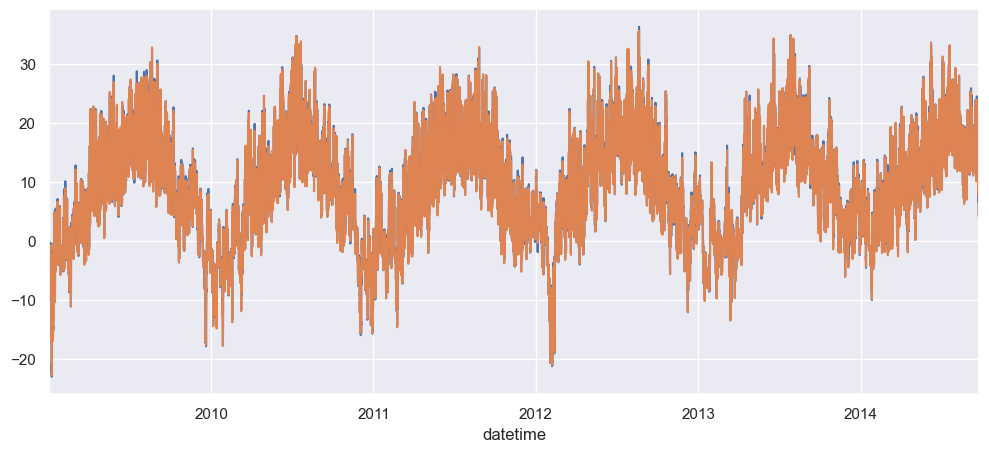

In [16]:
auto_arima_model.predict_in_sample(n_periods=len(df)).plot()
df['T (degC)'].plot(figsize=(12,5))

In [61]:
# dividir el dataset en train y test 
period = 14*24
train = df.iloc[:-period]
test = df.iloc[-period:]

In [62]:
# predict values on test data
predictions = auto_arima_model.predict(n_periods=len(test),
    return_conf_int=True,
    freq = 'H',
    alpha=0.05)

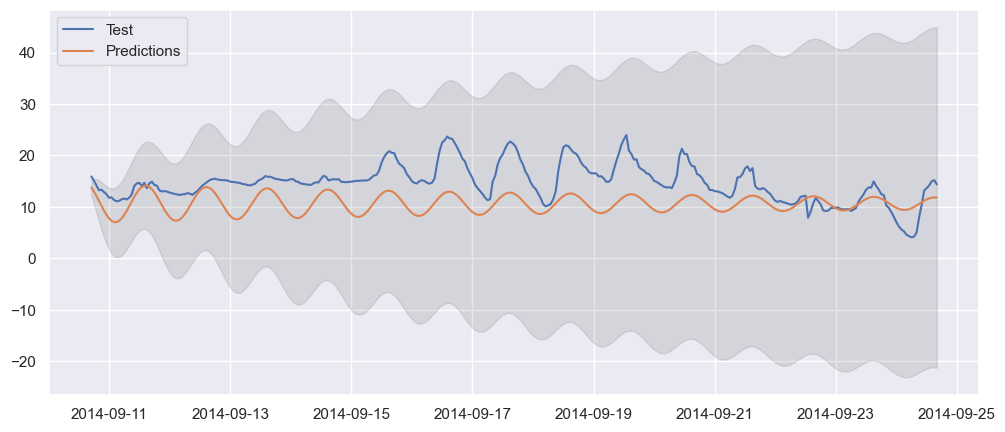

In [63]:
# plot predicted values vs real test values
plt.figure(figsize=(12,5))
# plt.plot(train.index, train['T (degC)'], label='Train')
plt.plot(test.index, test['T (degC)'], label='Test')
plt.plot(test.index, predictions[0], label='Predictions')  # Extract predicted values
plt.fill_between(test.index, predictions[1][:,0], predictions[1][:,1], color='k', alpha=0.1)  # Extract confidence intervals
plt.legend()
plt.show()

In [34]:
# Obtener predicciones y intervalos de confianza con un nivel de confianza del 80%
predictions, conf_int = auto_arima_model.predict_in_sample(n_periods=len(df), 
    start='2014-09-01', 
    end='2014-09-24', 
    freq = 'H',
    return_conf_int=True, 
    alpha=0.5)  # 80% de confianza

actual = df['T (degC)']['2014-09-01':'2014-09-24']

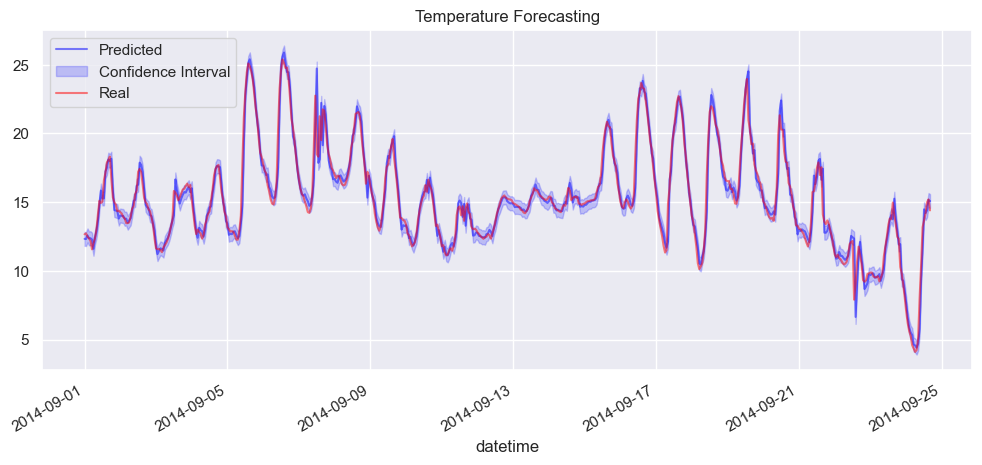

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(predictions, label='Predicted', color='blue', alpha=0.5)
plt.fill_between(predictions.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='blue', 
                 alpha=0.2)

df['T (degC)']['2014-09-01':'2014-09-24'].plot(legend=True, color='red', alpha=0.5, label='Real')

plt.legend(['Predicted', 'Confidence Interval', 'Real'])
plt.title('Temperature Forecasting')
plt.show()

In [9]:
len(actual), len(predictions)

(569, 569)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 0.4487424904728401
MSE: 0.5374155819027927
RMSE: 0.7330863400055908
MAPE: 0.0306230572925751


<Axes: title={'center': 'Temperature Forecasting'}, xlabel='datetime'>

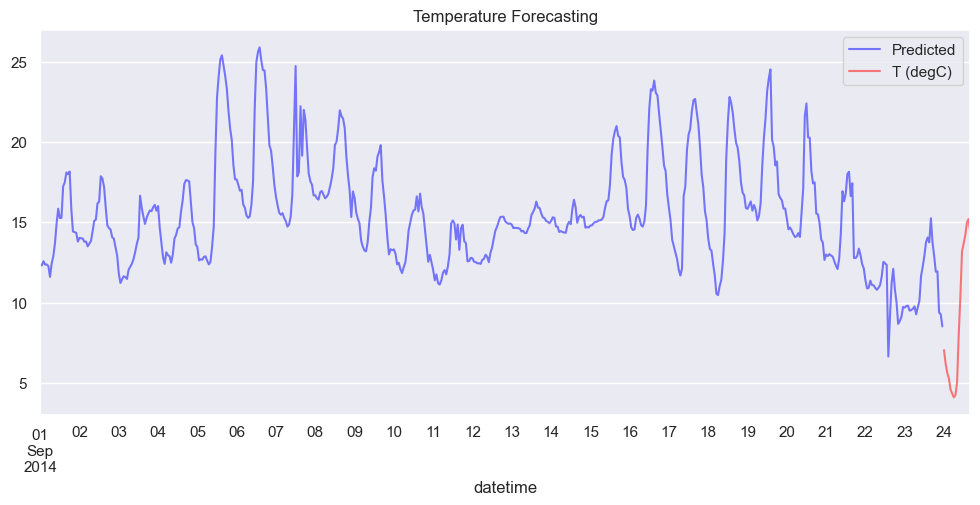

In [33]:
auto_arima_model.predict_in_sample(n_periods=len(df), 
    start='2014-09-01', 
    end='2014-09-23').plot(legend=True, color='blue', alpha=0.5, figsize=(12,5), label='Predicted', title='Temperature Forecasting')
df['T (degC)']['2014-09-24':'2014-09-27'].plot(figsize=(12,5), legend=True, color='red', alpha=0.5)